# Environment Prepare

## Install packages

In [ ]:
!pip install ultralytics
!pip install google-cloud-vision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

## Import Libraries

In [ ]:
import os
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive, files
import re
from google.cloud import vision

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Mount Google Drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load the YOLO models

In [ ]:
vehicle_detector = YOLO("yolo11n.pt")
license_plate_detector = YOLO('/content/gdrive/My Drive/SLP-split/models/license_plate_detector.pt')
license_plate_segmenter = YOLO('/content/gdrive/My Drive/SLP-split/models/license_plate_segmenter.pt')
vehicle_classes = [2, 5, 7]
# 2: car
# 5: bus
# 7: truck

100%|██████████| 5.35M/5.35M [00:00<00:00, 62.2MB/s]


# Models info

In [ ]:
vehicle_detector.info()

YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(319, 2624080, 0, 6.614336)

In [ ]:
license_plate_detector.info()

YOLO11n summary: 319 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs


(319, 2590035, 0, 6.4406016)

In [ ]:
license_plate_splitor.info()

YOLO11n summary: 319 layers, 2,590,230 parameters, 0 gradients, 6.4 GFLOPs


(319, 2590230, 0, 6.4416768)

## Open file dialog to select an image

Saving IMG_4608.jpg to IMG_4608.jpg


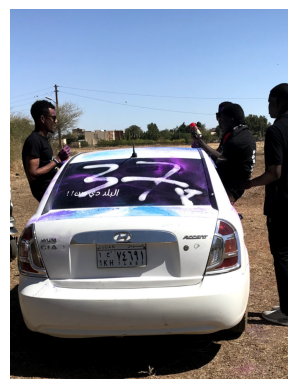

In [ ]:
# Upload the image
uploaded = files.upload()

# Extract the filename
filename = list(uploaded.keys())[0]

# Read the image using cv2
image = cv2.imread(filename)
original_image = image.copy()

# Convert the image to RGB (for displaying with matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Save the image
plt.savefig('Original Image.jpg')

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


# Detect vehicles

In [ ]:
vehicles = vehicle_detector(image)[0]


0: 640x480 4 persons, 1 car, 283.7ms
Speed: 19.9ms preprocess, 283.7ms inference, 49.5ms postprocess per image at shape (1, 3, 640, 480)


car 0.88
coordinates are ((34.99577331542969, 860.3463745117188), (1521.32373046875, 2085.910888671875))
Saved: /content/Vehicle Detection - raw.jpg


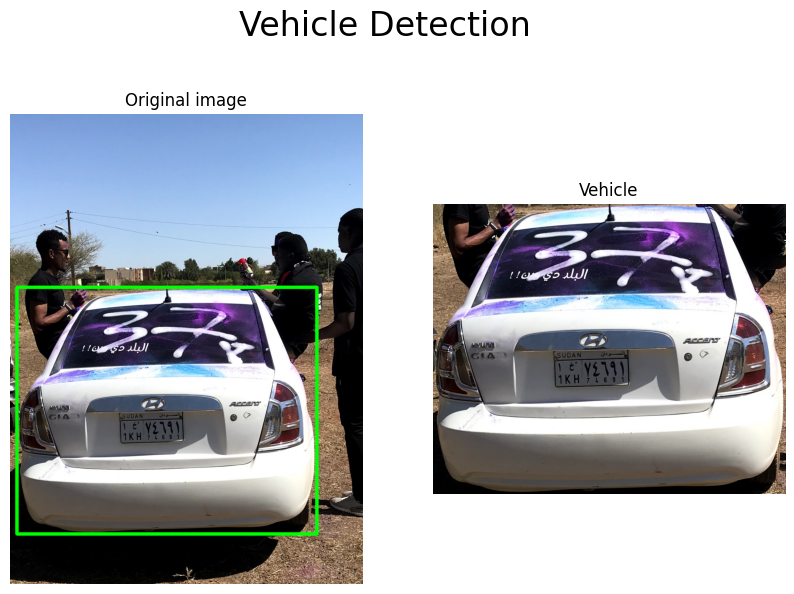

In [ ]:
vehicle = []  # To store cropped vehicle and its position
detections = []
for detection in vehicles.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = detection
    if int(class_id) in vehicle_classes and score > 0.70:
        detections.append([x1, y1, x2, y2, score])

        # Vehicle cropping
        cropped_vehicle = original_image[int(y1):int(y2), int(x1): int(x2), :]
        vehicle = (x1, y1, x2, y2)

        # draw vehicle border
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 15)
        # label = f'{vehicle_detector.names[class_id]} {score:.2f}'
        # cv2.putText(image, label, (int(x1), int(y1)-20), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
        print(f'{vehicle_detector.names[class_id]} {score:.2f}')
        print(f'coordinates are (({x1}, {y1}), ({x2}, {y2}))')


# Convert the image to RGB (for displaying with matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_vehicle_rgb = cv2.cvtColor(cropped_vehicle, cv2.COLOR_BGR2RGB)

# Save images to pass them to the OCR
save_path = f'/content/Vehicle Detection - raw.jpg'
c_save_path = f'/content/Cropped vehicle.jpg'
pil_img = Image.fromarray(image_rgb)
c_pil_img = Image.fromarray(cropped_vehicle_rgb)
try:
    pil_img.save(save_path)
    c_pil_img.save(c_save_path)
    print(f'Saved: {save_path}')
except Exception as e:
    print(f'Error while saving {save_path}: {e}')

# Display the image
fig = plt.figure(figsize=(10, 7))
# Add the Original image to the figure
plt.subplot(1, 2, 1)  # 1 rows, 2 columns, first position
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis labels
plt.title("Original image")
# Add the Vehicle image to the figure
plt.subplot(1, 2, 2)  # 1 rows, 2 columns, second position
plt.imshow(cropped_vehicle_rgb)
plt.axis('off')  # Hide the axis labels
plt.title("Vehicle")
# Set the figure title
subtitle = fig.suptitle('Vehicle Detection')
subtitle.set(**{'fontsize': 24})
# Save the image
plt.savefig('Vehicle Detection.jpg')
# Show the image
plt.show()

# Detect license plates

In [ ]:
license_plates = license_plate_detector(cropped_vehicle)[0]


0: 544x640 1 License_Plate, 217.3ms
Speed: 7.0ms preprocess, 217.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


License_Plate 0.86
coordinates are ((519.2962799072266, 1451.6849365234375), (885.7723236083984, 1679.8739013671875))
Saved: /content/License Plate Detection - raw.jpg


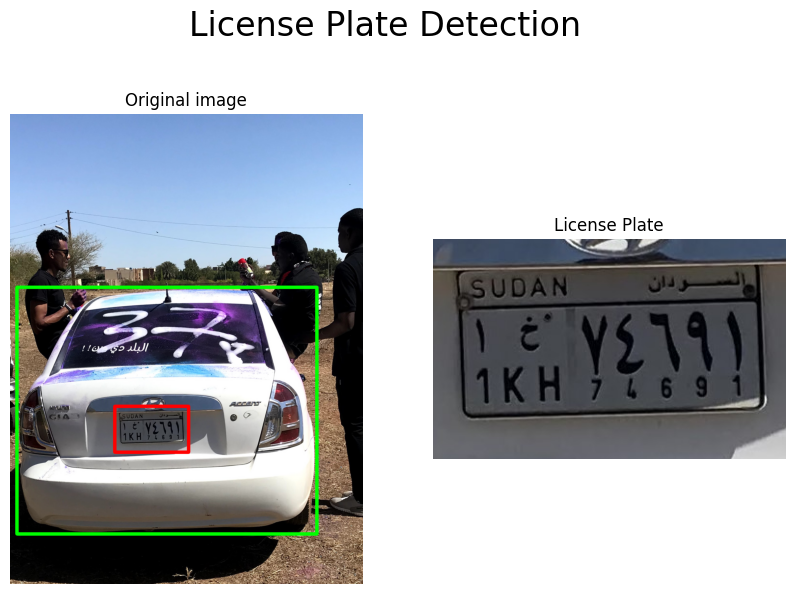

In [ ]:
x1_vehicle, y1_vehicle, x2_vehicle, y2_vehicle = vehicle # position of cropped vehicle
lp = []  # To store cropped license plate and its position

for license_plate in license_plates.boxes.data.tolist():
  x1, y1, x2, y2, score, class_id = license_plate

  # License plate cropping
  cropped_license_plate = cropped_vehicle[int(y1):int(y2), int(x1): int(x2), :]

  # Adjust coordinates to original image
  adjusted_x1 = x1_vehicle + x1
  adjusted_y1 = y1_vehicle + y1
  adjusted_x2 = x1_vehicle + x2
  adjusted_y2 = y1_vehicle + y2

  lp = [adjusted_x1, adjusted_y1, adjusted_x1, adjusted_y1]

  # draw license plate border
  cv2.rectangle(image, (int(adjusted_x1), int(adjusted_y1)), (int(adjusted_x2), int(adjusted_y2)), (0, 0, 255), 15)
  # cv2.putText(image, f'LP {score:.2f}', (int(adjusted_x1), int(adjusted_y1)-20), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 5)
  print(f'{license_plate_detector.names[class_id]} {score:.2f}')
  print(f'coordinates are (({adjusted_x1}, {adjusted_y1}), ({adjusted_x2}, {adjusted_y2}))')


# Convert the image to RGB (for displaying with matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_license_plate_rgb = cv2.cvtColor(cropped_license_plate, cv2.COLOR_BGR2RGB)


# Save images to pass them to the OCR
save_path = f'/content/License Plate Detection - raw.jpg'
c_save_path = f'/content/Cropped license plate.jpg'
pil_img = Image.fromarray(image_rgb)
c_pil_img = Image.fromarray(cropped_license_plate_rgb)
try:
    pil_img.save(save_path)
    c_pil_img.save(c_save_path)
    print(f'Saved: {save_path}')
except Exception as e:
    print(f'Error while saving {save_path}: {e}')


# Display the image
fig = plt.figure(figsize=(10, 7))
# Add the Original image to the figure
plt.subplot(1, 2, 1)  # 1 rows, 2 columns, first position
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis labels
plt.title("Original image")
# Add the Original image to the figure
plt.subplot(1, 2, 2)  # 1 rows, 2 columns, second position
plt.imshow(cropped_license_plate_rgb)
plt.axis('off')  # Hide the axis labels
plt.title("License Plate")
# Set the figure title
subtitle = fig.suptitle('License Plate Detection')
subtitle.set(**{'fontsize': 24})
# Save the image
plt.savefig('License Plate Detection.jpg')
plt.show()

# Segment lisence plate

In [ ]:
results = license_plate_segmenter(cropped_license_plate)[0]


0: 416x640 1 SCode, 1 Numbers, 174.7ms
Speed: 5.3ms preprocess, 174.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Saved: /content/cropped_state_code.jpg
SCode 0.95
coordinates are ((560.1891136169434, 1528.4439697265625), (655.1395721435547, 1625.7692108154297))
Saved: /content/cropped_numbers.jpg
Numbers 0.94
coordinates are ((671.1923370361328, 1523.4929656982422), (845.8994903564453, 1621.4758758544922))
Saved: /content/License Plate Segmentation - raw.jpg


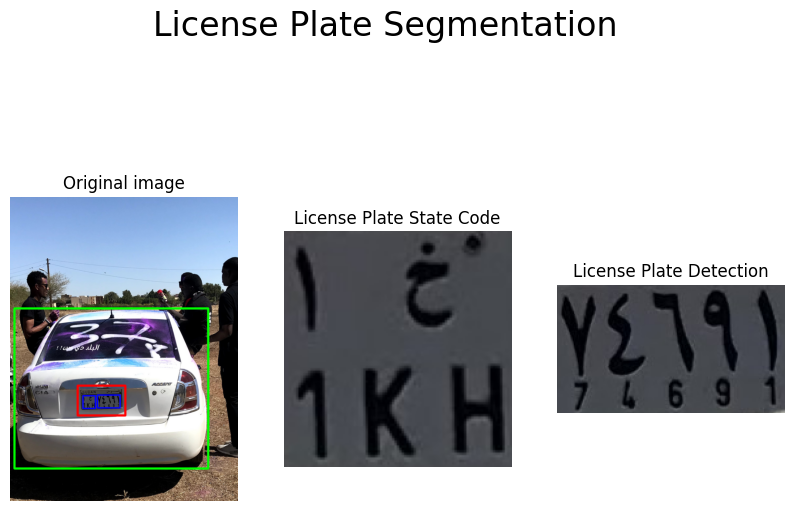

In [ ]:
x1_lp, y1_lp, x2_lp, y2_lp = lp # position of cropped license plate

for result in results.boxes.data.tolist():
  x1, y1, x2, y2, score, class_id = result
  # x1, y1, x2, y2, score, class_id = result[:6]
  if int(class_id) == 0:
    # State code cropping
    cropped_state_code = cropped_license_plate[int(y1):int(y2), int(x1): int(x2), :]
    # Set image path
    save_path = f'/content/cropped_state_code.jpg'
    pil_img = Image.fromarray(cropped_state_code)
  elif int(class_id) == 1:
    # Numbers cropping
    cropped_numbers = cropped_license_plate[int(y1):int(y2), int(x1): int(x2), :]
    # Set image path
    save_path = f'/content/cropped_numbers.jpg'
    pil_img = Image.fromarray(cropped_numbers)

  # Save images to pass them to the OCR
  try:
      pil_img.save(save_path)
      print(f'Saved: {save_path}')
  except Exception as e:
      print(f'Error while saving {save_path}: {e}')

  # Adjust coordinates to original image
  adjusted_x1 = x1_lp + x1
  adjusted_y1 = y1_lp + y1
  adjusted_x2 = x1_lp + x2
  adjusted_y2 = y1_lp + y2

  # draw borders
  cv2.rectangle(image, (int(adjusted_x1), int(adjusted_y1)), (int(adjusted_x2), int(adjusted_y2)), (255, 0, 0), 10)
  # label = f'{license_plate_splitor.names[class_id]} {score:.2f}'
  # cv2.putText(image, label, (int(adjusted_x1), int(adjusted_y1)-15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
  print(f'{license_plate_splitor.names[class_id]} {score:.2f}')
  print(f'coordinates are (({adjusted_x1}, {adjusted_y1}), ({adjusted_x2}, {adjusted_y2}))')


# Convert the image to RGB (for displaying with matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_state_code_rgb = cv2.cvtColor(cropped_state_code, cv2.COLOR_BGR2RGB)
cropped_numbers_rgb = cv2.cvtColor(cropped_numbers, cv2.COLOR_BGR2RGB)


# Save images to pass them to the OCR
save_path = f'/content/License Plate Segmentation - raw.jpg'
pil_img = Image.fromarray(image_rgb)
try:
    pil_img.save(save_path)
    print(f'Saved: {save_path}')
except Exception as e:
    print(f'Error while saving {save_path}: {e}')


# Display the image
fig = plt.figure(figsize=(10, 7))
# Add the Original image to the figure
plt.subplot(1, 3, 1)  # 1 rows, 3 columns, first position
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis labels
plt.title("Original image")
# Add the Original image to the figure
plt.subplot(1, 3, 2)  # 1 rows, 3 columns, second position
plt.imshow(cropped_state_code_rgb)
plt.axis('off')  # Hide the axis labels
plt.title("License Plate State Code")
# Add the Original image to the figure
plt.subplot(1, 3, 3)  # 1 rows, 3 columns, third position
plt.imshow(cropped_numbers_rgb)
plt.axis('off')  # Hide the axis labels
plt.title("License Plate Numbers")
# Set the figure title
plt.title('License Plate Detection')
# Set the figure title
subtitle = fig.suptitle('License Plate Segmentation')
subtitle.set(**{'fontsize': 24})
# Save the image
plt.savefig('License Plate Segmentation.jpg')
plt.show()

# Character Recognition

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/content/gdrive/MyDrive/SLP-split/vision_key.json'
WORD = re.compile(r"\w+")

In [ ]:
def detect_text(path):
    client = vision.ImageAnnotatorClient()

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # for non-dense text
    response = client.text_detection(image=image)

    # for dense text
    # response = client.document_text_detection(image=image)
    texts = response.text_annotations
    ocr_text = []

    for text in texts:
        ocr_text.append(text.description)

        vertices = [
            f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices
        ]


    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )
    return vertices, ocr_text

In [ ]:
SC_vertices, SC_text = detect_text('/content/cropped_state_code.jpg')
N_vertices, N_text = detect_text('/content/cropped_numbers.jpg')

In [ ]:
print(SC_text[0])
print(N_text[0].replace(" ", ""))

1KH
٧٤٦٩١
74691


In [ ]:
for SC_line, N_line in zip(SC_text, N_text):
    print(SC_line)
    print(N_line)